(probabilistic_networks)=
# Creating and manipulating networks of probabilistic nodes

[pyhgf](https://ilabcode.github.io/pyhgf/index.html#) is designed with inspiration from graph neural network libraries that manipulates networks of probabilistic nodes and performs beliefs propagation using dedicated variational message passing. While this library is well-suited and optimized to implement the standard two-level and three-level HGF, it can target much larger use cases and generalize to any kind of probabilistic network. More specifically, the four main components of a network for predictive coding applications, which are:
1. network structure
2. the network parameters
3. the update function
4. the update sequence
are all made modular and dynamically accessible during the inference processes, allowing the creation of agents that can also manipulate these components. 

In this notebook, we dive into the details of creating such networks and illustrate their modularity.

## Creating networks of probabilistic nodes

Any form of generalized Hierarchical Gaussian Filter can be fully determined by the following variables. Let 

$$\mathcal{HGF}_{k} = \{\theta, \xi, \mathcal{F}, \Sigma \}$$ 

be the HGF model with $K$ probabilistic nodes with 

$$\theta = \{\theta_1, ..., \theta_{k}\}$$ 

a set of parameters. Nodes' parameters can be used to register sufficient statistics of the distributions as well as various coupling weights. The *shape* of the hierarchical structure is defined by the [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list)

$$\xi = \{\xi_1, ..., \xi_{k} \}$$

where every edge $\xi_k$ contains $m$ sets of node indexes, $m$ being the adjacency dimension (here we only consider value and volatility coupling, therefore $m=2$). The propagation of precision-weighted prediction error under new observations (or other generic belief propagation dynamics) are defined by the set of $n$ update functions

$$\mathcal{F} = \{f_1, ..., f_n\}$$

Each update function is parametrized by a node index $n \in 1, ..., k$ and the current state of the HGF model at time $t$. The most standard uses of the HGF only require continuous and/or binary update functions for input and states node. The propagation dynamics (the direction of the information flow) are controlled by the ordered update sequence

$$\Sigma = [f_1(n_1), ..., f_i(n_j), f \in \mathcal{F}, n \in 1, ..., k ]$$,

Each item of this sequence pairs a node index with an update function as previously defined.

![graph_networks](../images/graph_networks.svg)

### Implementation details

Networks are represented by two variables and two sets of functions:

1. a dictionary `parameter_structure` that registers the nodes' parameters.
2. a named tuple `node_structure` that encodes the [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list) (see the [Indexes](#pyhgf.typing.Indexes)).
2. updates functions (see e.g. the {ref}`pyhgf.continuous` and {ref}`pyhgf.continuous` modules)
4. an update sequence as a tuple of function/index pairs.

```{tip}
The update function should treat `node_structure` as a static argument and `parameter_structure` as a dynamic variable to comply with JAX JIT compilation (see [the documattion](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#jit-mechanics-tracing-and-static-variables) on that point).
```

### Creating nodes

In [1]:
from pyhgf.typing import Indexes
parameters = {"mu": 0.0, "pi": 1.0}

parameters_structure = (parameters, parameters, parameters)
node_structure = (
    Indexes((1,), None, None, None),
    Indexes(None, (2,), (0,), None),
    Indexes(None, None, None, (1,)),
)

The code above illustrate the creation of a probabilistic network of 3 nodes with simple parameters sets $(\mu=0.0, \pi=1.0)$. Node 2 is the value parent of node 1. Node 3 is the value parent of node 2 and has no parents.

### Network visualization

Creating a continuous Hierarchical Gaussian Filter with 3 levels.


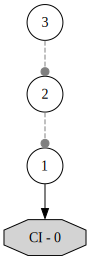

In [2]:
from pyhgf.model import HGF

# create a three-level HGF using default parameters
hgf = HGF(n_levels=3, model_type="continuous")
hgf.plot_network()

## Modifying the parameter structure

The simpler change we can make on a network is to change the values of some of its parameters. The parameters are stored in the `parameters_structure` variable as a dictionary where the key (integers) are node indexes. Therefore, modifying the expected precision of the third node in the previous example is as simple as:

In [3]:
hgf.parameters_structure[3]["pi"] = 5.0

However, modifying parameters values *manually* should not be that common as this is something we want the model to perform dynamically as we present new observations, but this can be used for example to generate prior predictive by sampling some parameter values from a distribution. 

```{note} What is a valid parameter/value?
A probabilistic node can store an arbitrary number of parameters. Parameter values should be valid JAX types, therefore a node cannot contain strings. You can provide additional parameters by using the `additional_parameters` arguments in {py:meth}`pyhgf.model.add_input_node`, {py:meth}`pyhgf.model.add_value_parent` and {py:meth}`pyhgf.model.add_volatility_parent`. Most of the nodes that are being used in the HGF use Gaussian distribution, therefore they contain the current mean and precision (`mu` and `pi`) as well as the expected mean and precision (`muhat` and `pihat`).
```

## Modifying the network structure

The second way we can modify a probabilistic network is by modifying its structure (i.e. the number of nodes, the type of nodes and the way they are connected with each other). Because nodes and connections are modular, a large variety of network structures can be declared. The only restrictions are that the network should be **acyclic** and **rooted** (the roots being input nodes).

For example, the following networks are valid HGF structures:

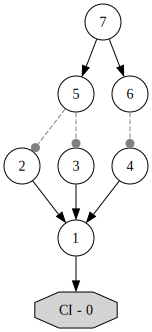

In [4]:
custom_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="continuous")
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[1])
    .add_volatility_parent(children_idxs=[2, 3])
    .add_volatility_parent(children_idxs=[4])
    .add_value_parent(children_idxs=[5, 6])
)
custom_hgf.plot_network()

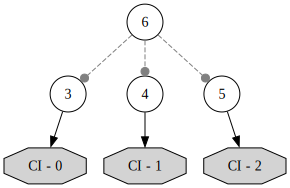

In [5]:
custom_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="continuous", input_idx=0)
    .add_input_node(kind="continuous", input_idx=1)
    .add_input_node(kind="continuous", input_idx=2)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_volatility_parent(children_idxs=[3, 4, 5])
)
custom_hgf.plot_network()

The structure of the probabilistic network is stored in the `node_structure` variable which consists of a tuple of `Indexes` that store the indexes of value/volatility parents/children for each node. For example, accessing the nodes connected to node `4` in the example above is done with:

In [6]:
# the node structure
custom_hgf.node_structure[4]

Indexes(value_parents=None, volatility_parents=(6,), value_children=(1,), volatility_children=None)

```{tip} Different types of coupling
Contrary to standard graph networks, the directed connection between nodes can have multiple forms. The standard HGF is built on combinations of *value coupling* and *volatility coupling* bindings, but this can be extended to an arbitrary number of types.
```

### Multivariate coupling

As we can see in the examples above, nodes in a valid HGF network can be influenced by multiple parents (either value or volatility parents). Similarly, a single node can be influenced by multiple children. This feature is termed *multivariate descendency* and *multivariate ascendency* (respectively) and is a central addition to the generalization of the HGF {cite:p}`weber:2023` that was implemented in this package, as well as in the [Julia counterpart](https://github.com/ilabcode/HierarchicalGaussianFiltering.jl).

```{note}
Hierarchical Gaussian Filters have often been described in terms of levels. For example, the two-level and three-level HGFs are specific instances of  node structures designed to track the volatility and meta-volatility of binary or continuous processes, respectively. While such models can easily be implemented in this framework, the notion of level itself is now less informative. This is a consequence of the multivariate control and influence properties, which can result in structures in which some nodes have a position in the hierarchy that cannot be clearly disambiguated.
```

#### The case of *multivariate descendency*

##### Value coupling

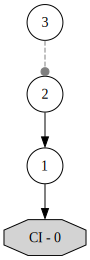

In [73]:
# creating a network that contains many child nodes are value coupled to one parent node
many_children_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="continuous")
    #.add_input_node(kind="continuous", input_idx=1)
    .add_value_parent(children_idxs=[0], omega=-10.0)
    #.add_value_parent(children_idxs=[1], omega=0.0)
    .add_value_parent(children_idxs=[1], omega=-3.0)
    .add_volatility_parent(children_idxs=[2])
    #.add_value_parent(children_idxs=[3], omega=-3.0)
    #.add_value_parent(children_idxs=[4, 5], omega=-3.0)
)

# plot the network
many_children_hgf.plot_network()

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# simulate some time series
u_0 = np.random.normal(0, 1, size=100)
u_1 = np.random.normal(0, 1, size=100)

u_0[20:50] += 5
u_0[90:] += 5

u_1[50:70] += 5
u_1[70:] += 5

input_data = np.array([u_0]).T

In [75]:
many_children_hgf.input_data(input_data=input_data)

Adding 100 new observations.


array([<Axes: >, <Axes: >], dtype=object)

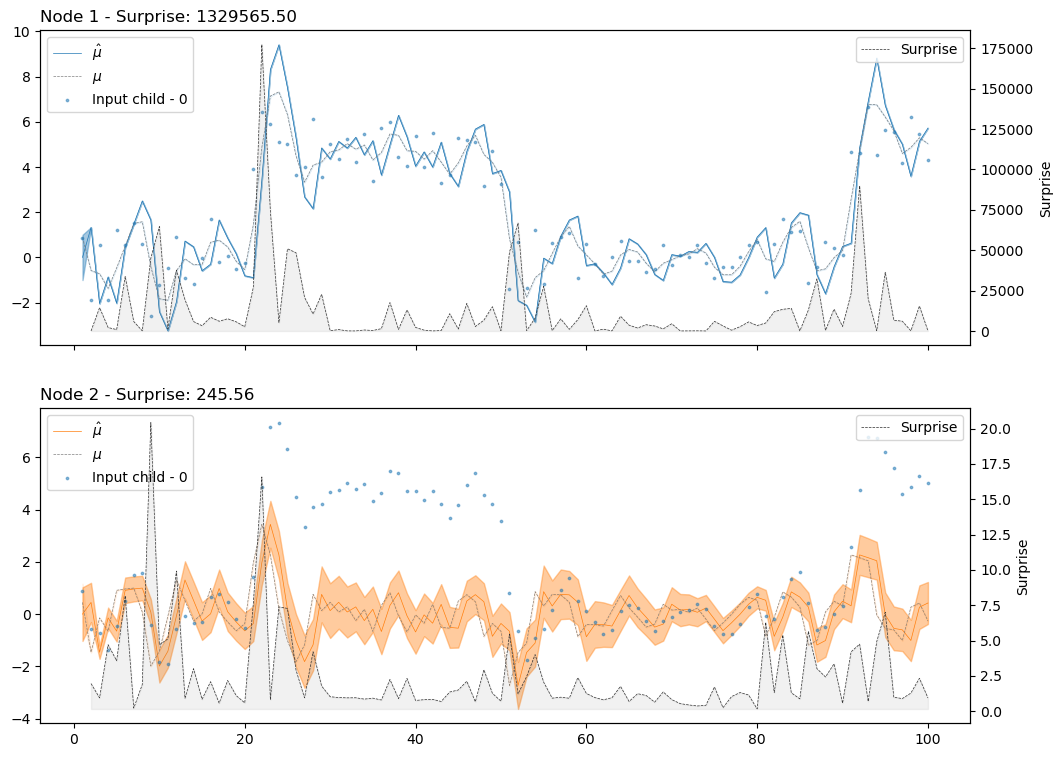

In [76]:
many_children_hgf.plot_nodes([1, 2], figsize=(12, 9))

In [78]:
many_children_hgf.parameters_structure

{0: {'kappas_parents': None,
  'omega': -9.210340371976182,
  'time_step': nan,
  'value': nan,
  'psis_parents': (1.0,)},
 1: {'mu': 0.0,
  'muhat': 0.0,
  'pi': 1.0,
  'pihat': 1.0,
  'kappas_children': None,
  'kappas_parents': None,
  'psis_children': (1.0,),
  'psis_parents': (1.0,),
  'nu': nan,
  'omega': -10.0,
  'rho': 0.0},
 2: {'mu': 0.0,
  'muhat': 0.0,
  'pi': 1.0,
  'pihat': 1.0,
  'kappas_children': None,
  'kappas_parents': (1.0,),
  'psis_children': (1.0,),
  'psis_parents': None,
  'nu': nan,
  'omega': -3.0,
  'rho': 0.0},
 3: {'mu': 0.0,
  'muhat': 0.0,
  'pi': 1.0,
  'pihat': 1.0,
  'kappas_children': (1.0,),
  'kappas_parents': None,
  'psis_children': None,
  'psis_parents': None,
  'nu': nan,
  'omega': -4.0,
  'rho': 0.0}}

KeyError: 'x_4_muhat'

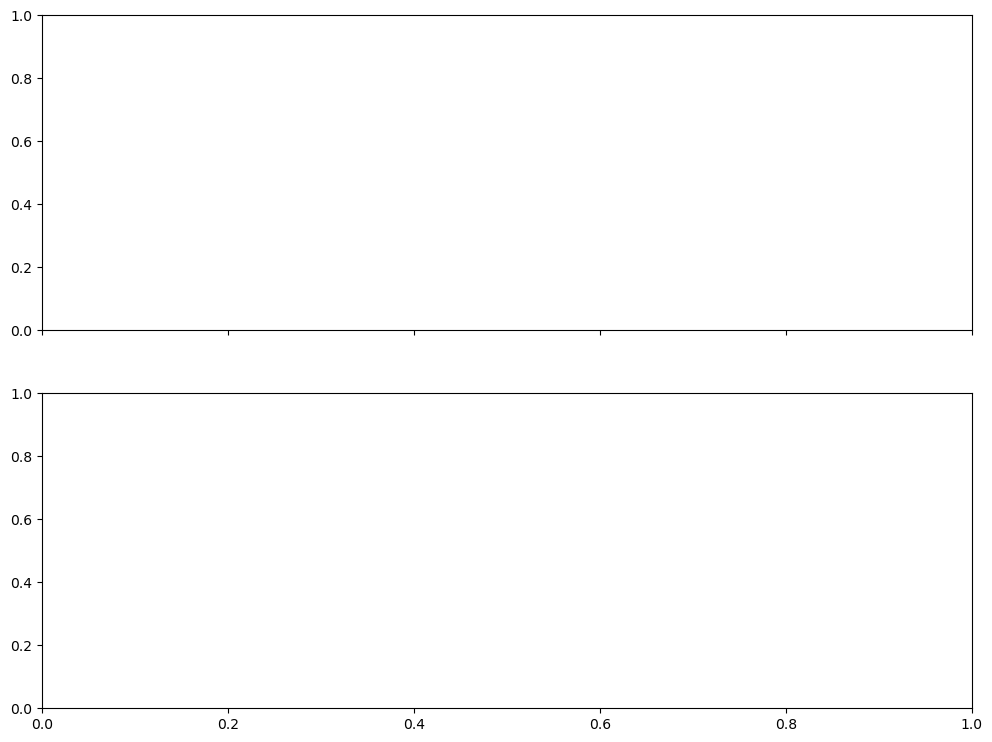

In [61]:
many_children_hgf.plot_nodes([4, 5], figsize=(12, 9))

[<Axes: >]

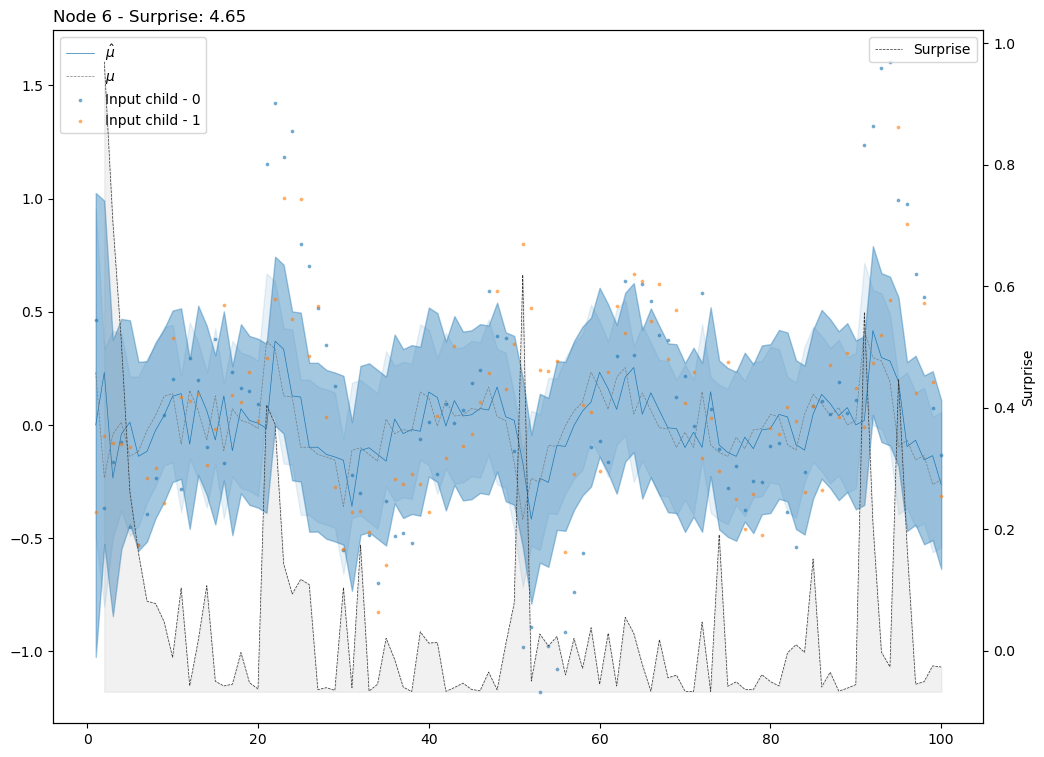

In [48]:
many_children_hgf.plot_nodes([6], figsize=(12, 9))

In [ ]:
plt.plot(u_0)
plt.plot(u_1)

##### Volatility coupling

In [ ]:
# creating a network that contains many child nodes are volatility coupled to one parent node
many_children_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="continuous")
    .add_input_node(kind="continuous", input_idx=1)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_volatility_parent(children_idxs=[2, 3])
)

# plot the network
many_children_hgf.plot_network()

#### The case of *multivariate ascendency*

## Creating custom update functions

Models that are created with parameter structures and node structures only represent static configuration of the HGF, they are not yet filtering new observation or acting in response to specific input. To add a dynamic and responsive layer, we need two additional components:

- update functions $\mathcal{F} = \{f_1, ..., f_n\}$
- update sequences $\Sigma = [f_1(n_1), ..., f_i(n_j), f \in \mathcal{F}, n \in 1, ..., k ]$,


### Update functions

Update functions are the heart of the HGF filtering procedure, these functions implement the message passing and parameters updating steps between node. An update function in its simplier form is a fuction defined as

```python
parameters_structure = update_fn(node_idx, parameters_structure, node_structure)
```

In other words, it is updating the parameters structure by applying certain transformation using the node $i$ as reference. This usually means that an observation has reached node $i$ and we want to send prediction-error to the parent nodes and update their sufficient statistics. The function has acess to the entire parameters and nodes structure, which mean that it can retrive parameters from parents, children, grand-parents etc... But in practice, pessage passing updates only use information found in the [Markov blanket](https://en.wikipedia.org/wiki/Markov_blanket) of the given node.

## Creating custom update sequences

Update sequences define the dynamics of beliefs propagation through the probabilistic network. In its simpler form, an update sequence is a sequence of update functions pointing to a node index such as:

```python
update_sequence = (
    (update_fn1, 0),
    (update_fn2, 1),
)
```

The HGF class include a built-in {ref}`pyhgf.modeal.HGF.get_update_sequence` method to automatically generate the update sequence from the network structure, assuming that we want to propagate the beliefs from the lower part of the tree (the input nodes) to its upper part (nodes that do not have parents).